# Random Forest

### Training model on complete dataset, i.e., with collinear features removed.

In [1]:
#Importing all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
#Providing dataset filepath

root="C:\\Users\\hmitt\\Downloads\\Team23_Project\\datasets\\"

In [3]:
#Reading the final dataset pickle file into a dataframe.

#df = pd.read_pickle(root+"corr_removed_feature_data.pkl")
df = pd.read_pickle("C:\\Users\\hmitt\\Python notebooks\\Updated_final_dataset.pkl")
df

,user_id,product_id,total_orders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order,is_reorder_3,is_reorder_2,is_reorder_1,...,orders_2,orders_1,reorder_3,reorder_2,reorder_1,hour_reorder_rate,day_reorder_rate,p_days_since_prior_order_reorder_rate,u_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate
0,1,196,10.0,0.900000,1.400000,17.593750,10.0,1.0,1.0,1.0,...,6,9,0.666667,1.0,0.666667,0.059092,0.152448,0.038340,0.242857,0.181818
1,1,10258,9.0,0.888889,3.333333,19.562500,10.0,1.0,1.0,1.0,...,6,9,0.666667,1.0,0.666667,0.061951,0.140488,0.040976,0.242857,0.200000
2,1,10326,1.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,...,6,9,0.666667,1.0,0.666667,0.067765,0.124264,0.035648,0.242857,0.000000
3,1,12427,10.0,0.900000,3.300000,17.593750,10.0,1.0,1.0,1.0,...,6,9,0.666667,1.0,0.666667,0.066149,0.130208,0.042108,0.242857,0.100000
4,1,13032,3.0,0.666667,6.333333,21.671875,10.0,1.0,0.0,0.0,...,6,9,0.666667,1.0,0.666667,0.063781,0.142418,0.033811,0.242857,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,206209,43961,3.0,0.666667,8.000000,23.328125,12.0,1.0,0.0,0.0,...,20,9,0.750000,0.7,0.444444,0.084418,0.140098,0.095451,0.343066,0.333333
8474657,206209,44325,1.0,0.000000,8.000000,9.000000,7.0,0.0,0.0,0.0,...,20,9,0.750000,0.7,0.444444,0.080154,0.152896,0.133132,0.343066,0.000000
8474658,206209,48370,1.0,0.000000,8.000000,30.000000,11.0,0.0,0.0,0.0,...,20,9,0.750000,0.7,0.444444,0.080864,0.136474,0.101748,0.343066,1.000000
8474659,206209,48697,1.0,0.000000,6.000000,9.000000,7.0,0.0,0.0,0.0,...,20,9,0.750000,0.7,0.444444,0.081864,0.153581,0.116048,0.343066,0.000000


In [4]:
def reduce_memory(df):
    
    """
    This function reduce the dataframe memory usage by converting it's type for easier handling.
    
    Parameters: Dataframe
    Return: Dataframe
    """
    
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        if df[col].dtypes in ["float64", "float32"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    
    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
    return df

In [5]:
#Reducing dataframe memory consumption for storage management.

df = reduce_memory(df)

Memory usage of properties dataframe is : 3620.7658081054688  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  986.0121173858643  MB
This is  27.232142857142858 % of the initial size


In [6]:
pd.set_option('display.max_columns', None)
df

,user_id,product_id,total_orders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order,is_reorder_3,is_reorder_2,is_reorder_1,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered,prod_add_to_cart_order_mean,prod_order_total,prod_reorder_rate,is_organic,aisle_add_to_cart_order_mean,aisle_order_total,aisle_reorder_rate,aisle_0,aisle_1,aisle_2,aisle_3,aisle_4,aisle_5,aisle_6,aisle_7,dept_add_to_cart_order_mean,dept_unique_users,department_0,department_1,department_2,department_3,department_4,dow_mean,dow_std,doh_mean,doh_std,days_since_prior_order_mean,days_since_prior_order_std,products_by_user,reorder_rate_by_user,order_size_avg,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,hour_reorder_rate,day_reorder_rate,p_days_since_prior_order_reorder_rate,u_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate
0,1,196,10.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14,1.0,3.722656,35791,0.776367,0,6.453125,357537,0.638672,0,0,1,1,0,1,1,1,6.976562,172795,0,0,0,1,1,2.644531,1.255859,10.539062,3.500000,18.546875,10.562500,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,0.059082,0.152466,0.038330,0.242798,0.181763
1,1,10258,9.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14,1.0,4.277344,1946,0.713867,0,9.320312,306487,0.519043,0,1,1,0,0,1,1,0,9.187500,174219,0,0,0,0,1,2.644531,1.255859,10.539062,3.500000,18.546875,10.562500,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,0.061951,0.140503,0.040985,0.242798,0.199951
2,1,10326,1.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,4.0,8.0,14,0.0,4.191406,5526,0.651855,0,7.144531,3642188,0.718262,0,1,0,1,0,0,1,0,8.023438,193237,0,1,1,1,0,2.644531,1.255859,10.539062,3.500000,18.546875,10.562500,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,0.067749,0.124268,0.035645,0.242798,0.000000
3,1,12427,10.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14,0.0,4.761719,6476,0.740723,0,8.460938,163524,0.591797,0,0,1,0,1,1,0,0,9.187500,174219,0,0,0,0,1,2.644531,1.255859,10.539062,3.500000,18.546875,10.562500,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,0.066162,0.130249,0.042114,0.242798,0.099976
4,1,13032,3.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,11.0,4.0,8.0,14,1.0,5.621094,3751,0.657227,0,9.046875,377586,0.571777,0,0,0,1,1,0,1,0,9.125000,114169,0,1,1,0,0,2.644531,1.255859,10.539062,3.500000,18.546875,10.562500,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,0.063782,0.142456,0.033813,0.242798,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,206209,43961,3.0,0.666504,8.000000,23.328125,12.0,1.0,0.0,0.0,14.0,6.0,14.0,30,0.0,9.195312,55371,0.630371,0,8.398438,1765313,0.638672,0,0,0,1,1,1,0,0,8.023438,193237,0,1,1,1,0,2.658203,1.538086,12.921875,2.738281,18.234375,10.921875,129,0.472900,9.921875,8,20,9,0.750000,0.700195,0.444336,0.084412,0.140137,0.095459,0.343018,0.333252
8474657,206209,44325,1.0,0.000000,8.000000,9.000000,7.0,0.0,0.0,0.0,14.0,6.0,14.0,30,0.0,10.109375,3485,0.401123,0,10.359375,266637,0.453125,0,0,0,1,1,1,1,0,10.210938,124820,0,1,0,1,0,2.658203,1.538086,12.921875,2.738281,18.234375,10.921875,129,0.472900,9.921875,8,20,9,0.750000,0.700195,0.444336,0.080139,0.152954,0.133179,0.343018,0.000000
8474658,206209,48370,1.0,0.000000,8.000000,30.000000,11.0,0.0,0.0,0.0,14.0,6.0,14.0,30,0.0,8.343750,3934,0.699219,0,7.824219,242996,0.527832,0,1,1,1,1,1,0,0,8.492188,111608,0,0,1,1,1,2.658203,1.538086,12.921875,2.738281,18.234375,10.921875,129,0.472900,9.921875,8,20,9,0.750000,0.700195,0.444336,0.080872,0.136475,0.101746,0.343018,1.000000
8474659,206209,48697,1.0,0.000000,6.000000,9.000000,7.0,0.0,0.0,0.0,14.0,6.0,14.0,30,0.0,8.765625,9783,0.357666,0,9.015625,245466,0.350830,0,0,1,1,1,0,1,1,9.593750,172755,0,0,0,1,0,2.658203,1.538086,12

In [7]:
df.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [8]:
df

,total_orders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order,is_reorder_3,is_reorder_2,is_reorder_1,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered,prod_add_to_cart_order_mean,prod_order_total,prod_reorder_rate,is_organic,aisle_add_to_cart_order_mean,aisle_order_total,aisle_reorder_rate,aisle_0,aisle_1,aisle_2,aisle_3,aisle_4,aisle_5,aisle_6,aisle_7,dept_add_to_cart_order_mean,dept_unique_users,department_0,department_1,department_2,department_3,department_4,dow_mean,dow_std,doh_mean,doh_std,days_since_prior_order_mean,days_since_prior_order_std,products_by_user,reorder_rate_by_user,order_size_avg,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,hour_reorder_rate,day_reorder_rate,p_days_since_prior_order_reorder_rate,u_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate
0,10.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14,1.0,3.722656,35791,0.776367,0,6.453125,357537,0.638672,0,0,1,1,0,1,1,1,6.976562,172795,0,0,0,1,1,2.644531,1.255859,10.539062,3.500000,18.546875,10.562500,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,0.059082,0.152466,0.038330,0.242798,0.181763
1,9.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14,1.0,4.277344,1946,0.713867,0,9.320312,306487,0.519043,0,1,1,0,0,1,1,0,9.187500,174219,0,0,0,0,1,2.644531,1.255859,10.539062,3.500000,18.546875,10.562500,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,0.061951,0.140503,0.040985,0.242798,0.199951
2,1.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,4.0,8.0,14,0.0,4.191406,5526,0.651855,0,7.144531,3642188,0.718262,0,1,0,1,0,0,1,0,8.023438,193237,0,1,1,1,0,2.644531,1.255859,10.539062,3.500000,18.546875,10.562500,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,0.067749,0.124268,0.035645,0.242798,0.000000
3,10.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14,0.0,4.761719,6476,0.740723,0,8.460938,163524,0.591797,0,0,1,0,1,1,0,0,9.187500,174219,0,0,0,0,1,2.644531,1.255859,10.539062,3.500000,18.546875,10.562500,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,0.066162,0.130249,0.042114,0.242798,0.099976
4,3.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,11.0,4.0,8.0,14,1.0,5.621094,3751,0.657227,0,9.046875,377586,0.571777,0,0,0,1,1,0,1,0,9.125000,114169,0,1,1,0,0,2.644531,1.255859,10.539062,3.500000,18.546875,10.562500,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,0.063782,0.142456,0.033813,0.242798,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,3.0,0.666504,8.000000,23.328125,12.0,1.0,0.0,0.0,14.0,6.0,14.0,30,0.0,9.195312,55371,0.630371,0,8.398438,1765313,0.638672,0,0,0,1,1,1,0,0,8.023438,193237,0,1,1,1,0,2.658203,1.538086,12.921875,2.738281,18.234375,10.921875,129,0.472900,9.921875,8,20,9,0.750000,0.700195,0.444336,0.084412,0.140137,0.095459,0.343018,0.333252
8474657,1.0,0.000000,8.000000,9.000000,7.0,0.0,0.0,0.0,14.0,6.0,14.0,30,0.0,10.109375,3485,0.401123,0,10.359375,266637,0.453125,0,0,0,1,1,1,1,0,10.210938,124820,0,1,0,1,0,2.658203,1.538086,12.921875,2.738281,18.234375,10.921875,129,0.472900,9.921875,8,20,9,0.750000,0.700195,0.444336,0.080139,0.152954,0.133179,0.343018,0.000000
8474658,1.0,0.000000,8.000000,30.000000,11.0,0.0,0.0,0.0,14.0,6.0,14.0,30,0.0,8.343750,3934,0.699219,0,7.824219,242996,0.527832,0,1,1,1,1,1,0,0,8.492188,111608,0,0,1,1,1,2.658203,1.538086,12.921875,2.738281,18.234375,10.921875,129,0.472900,9.921875,8,20,9,0.750000,0.700195,0.444336,0.080872,0.136475,0.101746,0.343018,1.000000
8474659,1.0,0.000000,6.000000,9.000000,7.0,0.0,0.0,0.0,14.0,6.0,14.0,30,0.0,8.765625,9783,0.357666,0,9.015625,245466,0.350830,0,0,1,1,1,0,1,1,9.593750,172755,0,0,0,1,0,2.658203,1.538086,12.921875,2.738281,18.234375,10.921875,129,0.472900,9.921875,8,20,9,0.750000,0.700195,0.444336,0.081848,0.153564,0.1160

In [9]:
#Taking a subset from complete dataset to train the model in stipulated time (complete dataset can be taken if we have more computation power).

df=df.sample(frac=.10)
df

,total_orders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order,is_reorder_3,is_reorder_2,is_reorder_1,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered,prod_add_to_cart_order_mean,prod_order_total,prod_reorder_rate,is_organic,aisle_add_to_cart_order_mean,aisle_order_total,aisle_reorder_rate,aisle_0,aisle_1,aisle_2,aisle_3,aisle_4,aisle_5,aisle_6,aisle_7,dept_add_to_cart_order_mean,dept_unique_users,department_0,department_1,department_2,department_3,department_4,dow_mean,dow_std,doh_mean,doh_std,days_since_prior_order_mean,days_since_prior_order_std,products_by_user,reorder_rate_by_user,order_size_avg,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,hour_reorder_rate,day_reorder_rate,p_days_since_prior_order_reorder_rate,u_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate
2114599,2.0,0.500000,4.000000,16.5,21.0,1.0,0.0,0.0,23.0,3.0,12.0,11,0.0,4.312500,4082,0.631836,0,7.144531,3642188,0.718262,0,1,0,1,0,0,1,0,8.023438,193237,0,1,1,1,0,3.595703,2.082031,13.578125,4.660156,14.914062,6.746094,109,0.568848,4.953125,4,7,5,0.750000,0.714355,0.600098,0.073059,0.134644,0.025055,0.121765,0.0
1086564,1.0,0.000000,3.000000,21.0,6.0,0.0,0.0,0.0,23.0,3.0,11.0,29,0.0,8.843750,5711,0.538574,0,7.144531,3642188,0.718262,0,1,0,1,0,0,1,0,8.023438,193237,0,1,1,1,0,4.984375,1.475586,14.335938,4.179688,11.390625,8.671875,282,0.287354,12.820312,37,8,15,0.486572,0.500000,0.133301,0.084778,0.107666,0.005516,0.027588,0.0
1793148,2.0,0.500000,5.500000,8.0,6.0,1.0,0.0,0.0,7.0,2.0,10.0,30,0.0,9.437500,313,0.469727,0,8.781250,305655,0.556152,0,0,0,1,1,1,1,1,8.531250,113891,0,1,0,0,1,2.255859,1.108398,9.570312,2.503906,11.335938,6.679688,86,0.406982,14.335938,20,15,14,0.399902,0.533203,0.856934,0.069702,0.115173,0.197021,0.054932,0.0
1214653,6.0,0.833496,10.335938,6.5,24.0,0.0,0.0,0.0,45.0,4.0,15.0,3,0.0,9.562500,11110,0.664062,0,8.867188,71742,0.529297,0,1,0,0,0,1,1,1,9.000000,163233,0,0,1,0,0,1.598633,2.361328,13.531250,3.119141,8.265625,4.535156,540,0.764648,12.273438,18,13,6,0.944336,0.846191,0.833496,0.084656,0.117126,0.067871,0.007355,0.0
7001895,1.0,0.000000,3.000000,11.0,4.0,0.0,0.0,0.0,7.0,0.0,10.0,14,0.0,7.132812,347,0.455322,0,7.332031,575881,0.663086,0,0,0,0,1,0,1,1,6.976562,172795,0,0,0,1,1,1.555664,1.931641,14.414062,3.042969,23.281250,8.898438,90,0.122192,15.000000,12,2,28,0.000000,0.000000,0.178589,0.055542,0.188843,0.030548,0.099976,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451079,1.0,0.000000,7.000000,23.0,2.0,0.0,0.0,0.0,8.0,1.0,21.0,6,0.0,9.031250,12056,0.606934,0,8.765625,395130,0.606445,0,0,1,1,0,0,0,1,8.695312,133865,1,0,0,0,1,3.128906,1.696289,14.632812,4.351562,23.859375,10.156250,77,0.324707,11.000000,11,8,8,0.454590,0.750000,0.375000,0.020142,0.191528,0.079529,0.083313,0.0
4632311,1.0,0.000000,6.000000,16.0,8.0,0.0,0.0,0.0,17.0,2.0,13.0,23,0.0,6.703125,46546,0.742188,0,6.085938,841533,0.729492,0,0,0,0,1,0,1,0,6.976562,172795,0,0,0,1,1,1.713867,2.042969,11.882812,3.580078,16.375000,10.585938,252,0.571289,15.750000,29,16,28,0.724121,0.812500,0.821289,0.084351,0.141846,0.007381,0.090271,0.0
5624023,2.0,0.500000,5.500000,3.5,2.0,0.0,0.0,0.0,29.0,0.0,13.0,28,0.0,10.875000,8423,0.552734,0,8.851562,3418021,0.594727,0,0,1,0,0,1,0,0,8.023438,193237,0,1,1,1,0,2.623047,2.416016,12.726562,4.324219,11.632812,7.996094,450,0.646484,16.078125,17,8,16,0.353027,0.250000,0.625000,0.078247,0.229004,0.006710,0.060547,0.0
5152890,2.0,0.500000,6.500000,14.5,15.0,0.0,0.0,0.0,20.0,1.0,11.0,30,0.0,9.695312,8548,0.592773,0,10.164062,218387,0.479004,0,0,1,1,0,0,0,0,10.210938,124820,0,1,0,1,0,2.425781,1.943359,14.750000,3.699219,9.921875,6.449219,214,0.481201,11.265625,5,5,5,0.600098,0.399902,0.600098,0.085510,0.180908,0.111694,0.050232,0.0


In [10]:
label = 'reordered'
x_cols = df.columns.drop('reordered')

In [11]:
X = df[x_cols]
y = df[label]

In [12]:
#Splitting the dataset into training and testing data.
#Stratify parameter below makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.
#For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(635599, 54) (635599,)
(211867, 54) (211867,)


In [13]:
y_train.value_counts()

0.0    573177
1.0     62422
Name: reordered, dtype: int64

In [14]:
#Determining parameter grid for estimator.

params={
    'max_depth': [3,4,5,10,15],
    'min_samples_split': [2,3,4,5],
    'class_weight': [{0:1, 1:10}]
}

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
rf=RandomForestClassifier()

In [17]:
#Using RandomizedSearchCV to cross-validate and perform hyper-parameter tuning.

from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = params, cv = 3, random_state=35, n_jobs = -1)

In [18]:
#Training the model.

rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'class_weight': [{0: 1, 1: 10}],
                                        'max_depth': [3, 4, 5, 10, 15],
                                        'min_samples_split': [2, 3, 4, 5]},
                   random_state=35)

In [19]:
y_pred_rf=rf_random.predict(X_test)

In [20]:
#Classifying output variable as 0 and 1 as per threshold value of 0.5

predictions_dt = [1 if i > 0.5 else 0 for i in y_pred_rf]


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.99      0.93      0.96    191059
         1.0       0.60      0.96      0.73     20808

    accuracy                           0.93    211867
   macro avg       0.80      0.94      0.85    211867
weighted avg       0.96      0.93      0.94    211867

Accuracy   Score :  0.9321366706471513
F1 Score:  0.7347232472324723


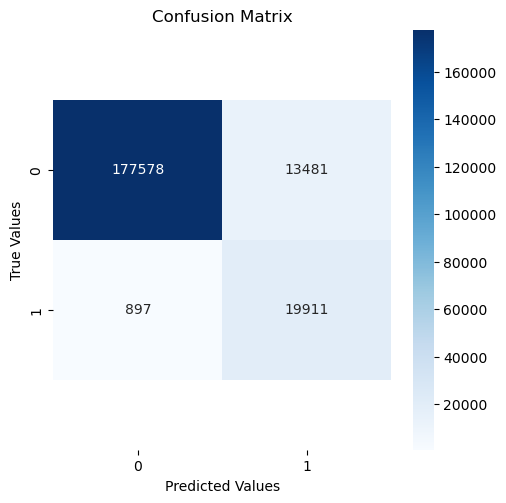

In [21]:
print ("\n Classification report : \n",classification_report(y_test, predictions_dt))
print ("Accuracy   Score : ",accuracy_score(y_test, predictions_dt))

#confusion matrix
conf_matrix_dt= confusion_matrix(y_test,predictions_dt)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix_dt, fmt = "d",annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

#f1-score
f1 = f1_score(y_test, predictions_dt)
print("F1 Score: ", f1)

In [ ]:
pickle.dump(rf_random, open("random_forest_model.pkl", "wb"))